In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "C:/Users/LENOVO/Desktop/US  E-commerce records 2020.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

df.columns = [col.strip().replace(" ", "_") for col in df.columns]

print(df.head())  # Display the first few rows of the DataFrame
print(df.columns)  # Display the column names of the DataFrame
print(df.info())  # Display information about the DataFrame 


  Order_Date  Row_ID        Order_ID       Ship_Mode Customer_ID      Segment  \
0   01-01-20     849  CA-2017-107503  Standard Class    GA-14725     Consumer   
1   01-01-20    4010  CA-2017-144463  Standard Class    SC-20725     Consumer   
2   01-01-20    6683  CA-2017-154466     First Class    DP-13390  Home Office   
3   01-01-20    8070  CA-2017-151750  Standard Class    JM-15250     Consumer   
4   01-01-20    8071  CA-2017-151750  Standard Class    JM-15250     Consumer   

         Country         City       State  Postal_Code   Region  \
0  United States       Lorain        Ohio        44052     East   
1  United States  Los Angeles  California        90036     West   
2  United States     Franklin   Wisconsin        53132  Central   
3  United States   Huntsville       Texas        77340  Central   
4  United States   Huntsville       Texas        77340  Central   

        Product_ID         Category Sub-Category  \
0  FUR-FU-10003878        Furniture  Furnishings   
1  FUR

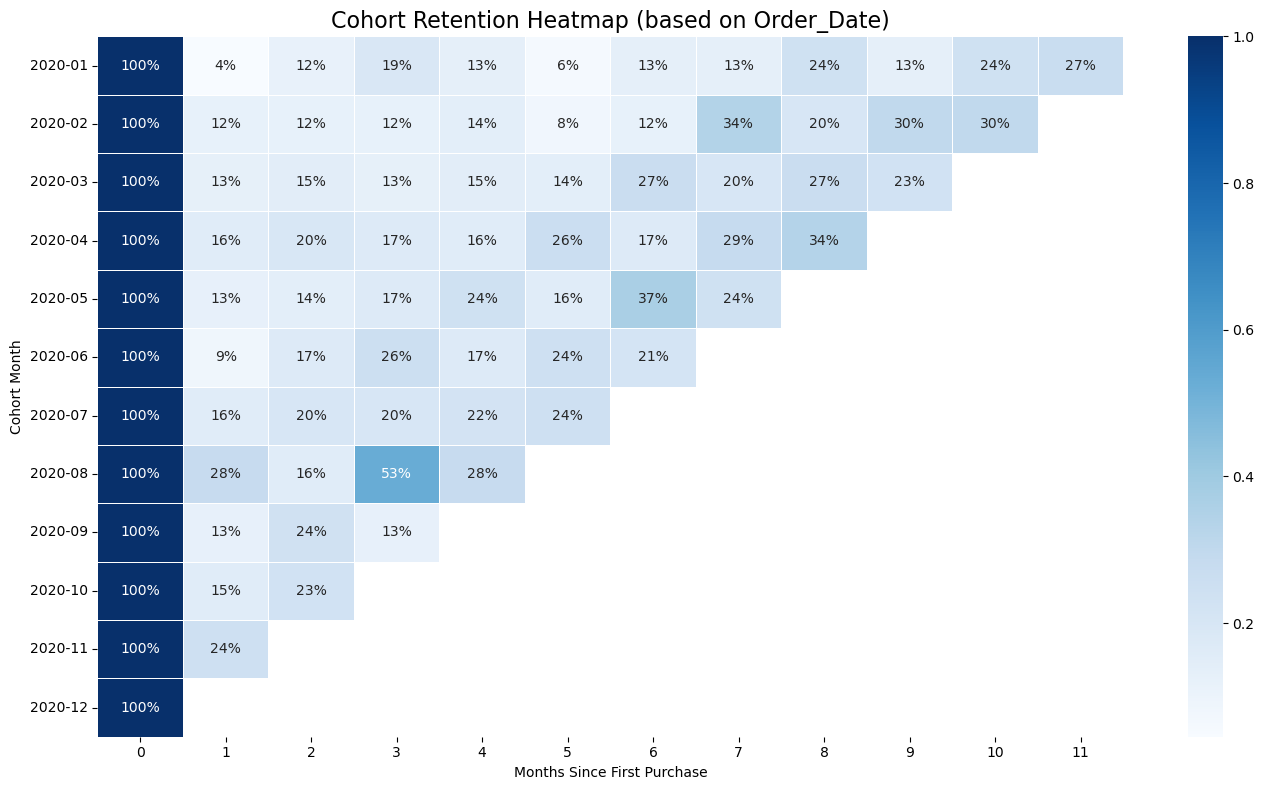

In [ ]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%y')

# OrderMonth, CohortMonth 생성
df['OrderMonth'] = df['Order_Date'].dt.to_period('M')
df['CohortMonth'] = df.groupby('Customer_ID')['OrderMonth'].transform('min')

# CohortIndex 계산
def get_month_diff(row):
    return (row['OrderMonth'].year - row['CohortMonth'].year) * 12 + (row['OrderMonth'].month - row['CohortMonth'].month)

df['CohortIndex'] = df.apply(get_month_diff, axis=1)

# 코호트 피벗 테이블 생성
cohort_counts = df.groupby(['CohortMonth', 'CohortIndex'])['Customer_ID'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='CohortMonth', columns='CohortIndex', values='Customer_ID')

# 리텐션 테이블 생성
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

# 리텐션 히트맵 시각화
plt.figure(figsize=(14, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues', linewidths=0.5)
plt.title('Cohort Retention Heatmap (based on Order_Date)', fontsize=16)
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.tight_layout()
plt.show()

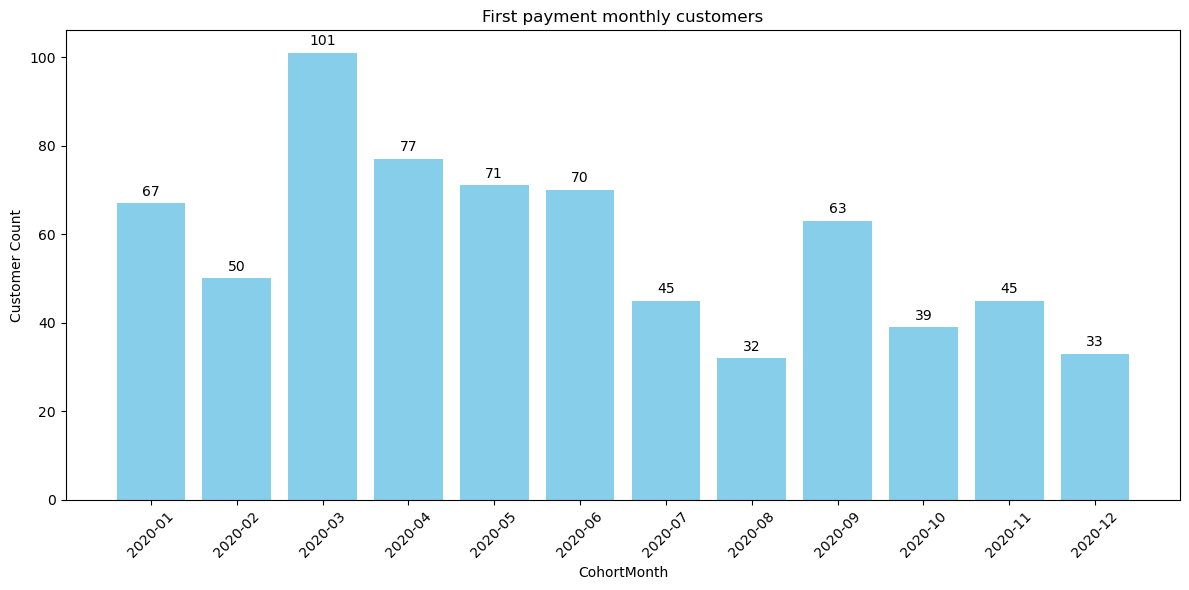

In [18]:
# month0 데이터 추출 (CohortIndex == 0인 고객 수)
month0_data = cohort_pivot.iloc[:, 0].reset_index()
month0_data.columns = ['CohortMonth', 'CustomerCount']

# 문자열로 바꿔서 보기 편하게
month0_data['CohortMonth'] = month0_data['CohortMonth'].astype(str)

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(month0_data['CohortMonth'], month0_data['CustomerCount'], color='skyblue')
plt.title("First payment monthly customers")
plt.xlabel("CohortMonth")
plt.ylabel("Customer Count")

# 막대 위에 숫자 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

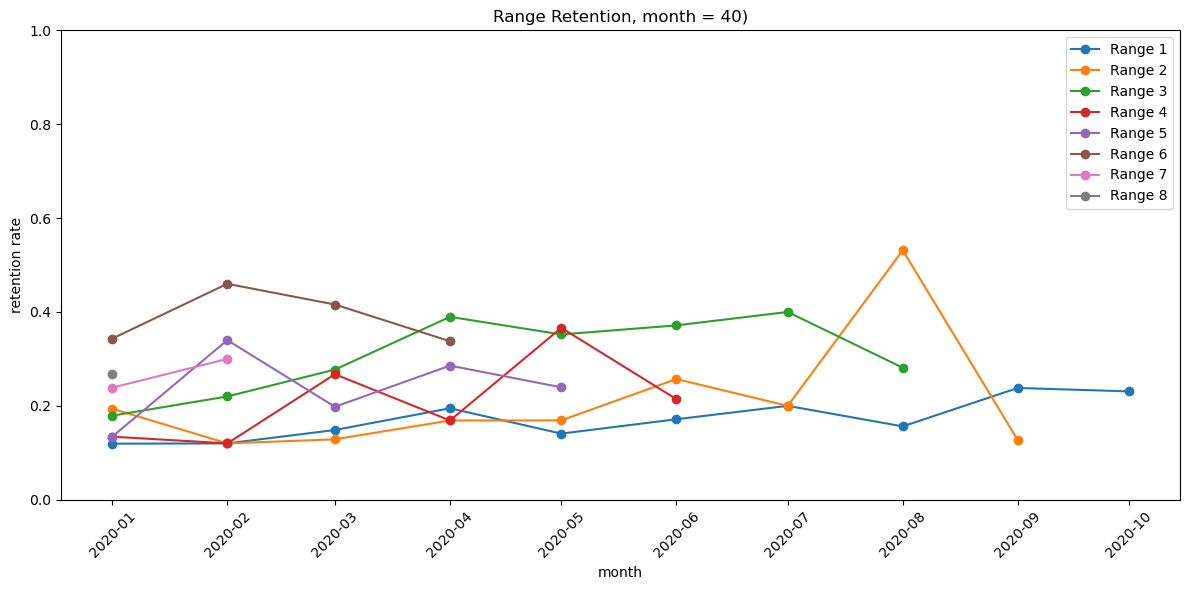

In [22]:
customer_stats = df.groupby('Customer_ID').agg(
    first_order_date=('Order_Date', 'min'),
    last_order_date=('Order_Date', 'max'),
    cnt_orders=('Order_ID', 'count')
).reset_index()

# Step 1: 구매 주기 계산
customer_stats['purchase_cycle'] = (
    (customer_stats['last_order_date'] - customer_stats['first_order_date']).dt.days
) / (customer_stats['cnt_orders'] - 1)

# 이상치 제외: 15일 ~ 300일 사이
valid_cycles = customer_stats[(customer_stats['purchase_cycle'] >= 15) & (customer_stats['purchase_cycle'] <= 300)]
median_cycle_days = int(valid_cycles['purchase_cycle'].median())

# Step 2: 원본 주문 데이터 기준으로 리텐션 분석을 위한 준비
df['OrderPeriod'] = df['Order_Date'].dt.to_period('M').dt.to_timestamp()
df['CohortMonth'] = df.groupby('Customer_ID')['Order_Date'].transform('min').dt.to_period('M').dt.to_timestamp()

# Cohort Index 계산 (주기 단위에 맞춘 Range Retention 구간)
df['CohortIndex'] = ((df['OrderPeriod'] - df['CohortMonth']).dt.days / median_cycle_days).apply(np.floor).astype(int)

# Step 3: Cohort별 리텐션 테이블 생성
cohort_group_size = df.groupby('CohortMonth')['Customer_ID'].nunique()
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer_ID'].nunique().unstack(1)
retention_rate = cohort_data.divide(cohort_group_size, axis=0)

# Step 4: 리텐션 추이 시각화 (Line Plot)
plt.figure(figsize=(12, 6))
for col in retention_rate.columns[1:]:  # range0 제외
    plt.plot(retention_rate.index, retention_rate[col], marker='o', label=f'Range {col}')
plt.title(f'Range Retention, month = {median_cycle_days})')
plt.xlabel('month')
plt.ylabel('retention rate')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()